# Libraries

In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid

import time
import random
from tqdm.notebook import tqdm

plt.style.use("dark_background")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


# Conf.

In [2]:
BASE_PATH= "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [3]:
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

# Get & Prepare Data

In [4]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])

[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [5]:
df.head()

dir_name                                         image_path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [6]:
df2 = pd.read_csv("/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv")
df2.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [7]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [8]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [9]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_50.tif*
 Belongs to the mask */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_50_mask.tif*


In [10]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

patient                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [11]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [12]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

patient                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  diagnosis  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0

In [13]:
dff.shape

(3929, 4)

In [14]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# EDA

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


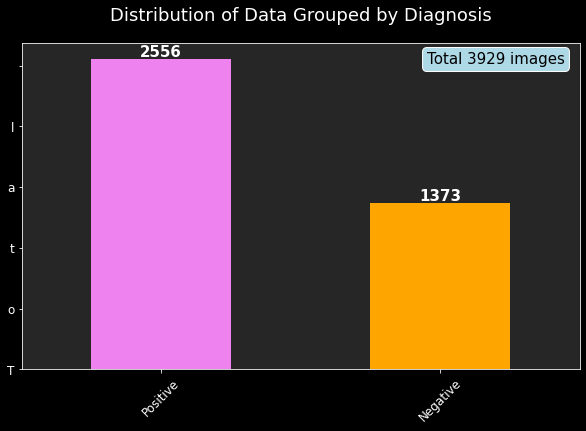

In [15]:
ax = dff.diagnosis.value_counts().plot(kind="bar",
                                stacked=True,
                                figsize=(10, 6),
                                color=["violet", "orange"])

ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12)
ax.set_yticklabels("Total Images", fontsize=12)
ax.set_title("Distribution of Data Grouped by Diagnosis", fontsize=18, y=1.05)

for i, rows in enumerate(dff.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(dff)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
         ))
ax.set_facecolor((0.15, 0.15, 0.15));

In [16]:
# returns how many diagnosed and non-diagnosed images each patient has
dff.groupby(["patient", "diagnosis"])["diagnosis"].size()

patient                diagnosis
TCGA_CS_4941_19960909  0            11
                       1            12
TCGA_CS_4942_19970222  0             8
                       1            12
TCGA_CS_4943_20000902  0             8
                                    ..
TCGA_HT_A616_19991226  1             4
TCGA_HT_A61A_20000127  0            71
                       1            17
TCGA_HT_A61B_19991127  0            62
                       1            26
Name: diagnosis, Length: 202, dtype: int64

In [17]:
patients_by_diagnosis = dff.groupby(["patient", "diagnosis"])["diagnosis"].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

patients_by_diagnosis.head()

Positive  Negative
patient                                  
TCGA_CS_4941_19960909      11.0      12.0
TCGA_CS_4942_19970222       8.0      12.0
TCGA_CS_4943_20000902       8.0      12.0
TCGA_CS_4944_20010208      17.0       3.0
TCGA_CS_5393_19990606      12.0       8.0

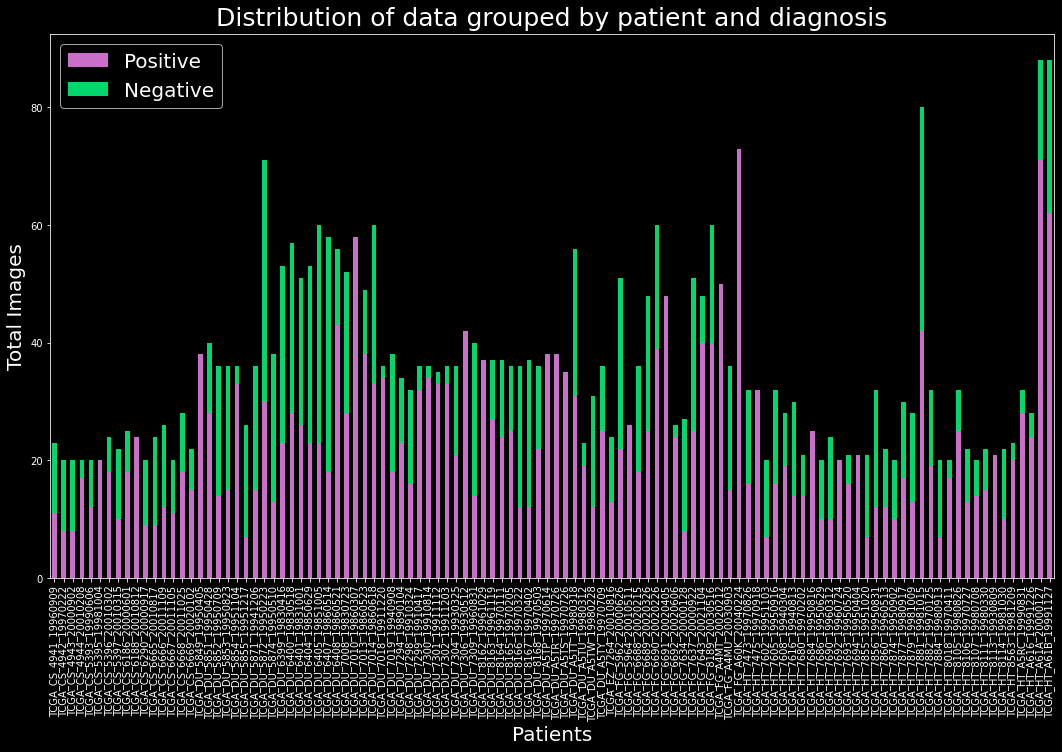

In [18]:
ax = patients_by_diagnosis.plot(kind="bar",
                          stacked=True,
                          figsize=(18,10),
                          color=["violet", "springgreen"],
                          alpha=0.85
                          )
ax.legend(fontsize=20, loc="upper left")
ax.grid(False)
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005);

# Visualize Data

In [19]:
sample_pos = dff[dff["diagnosis"] == 1].sample(5).image_path.values
sample_neg = dff[dff["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []

for i, (pos, neg) in enumerate(zip(sample_pos, sample_neg)):
    pos = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
    neg = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([pos, neg])
    
sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

In [20]:
sample_yes_arr.shape

(2560, 512, 3)

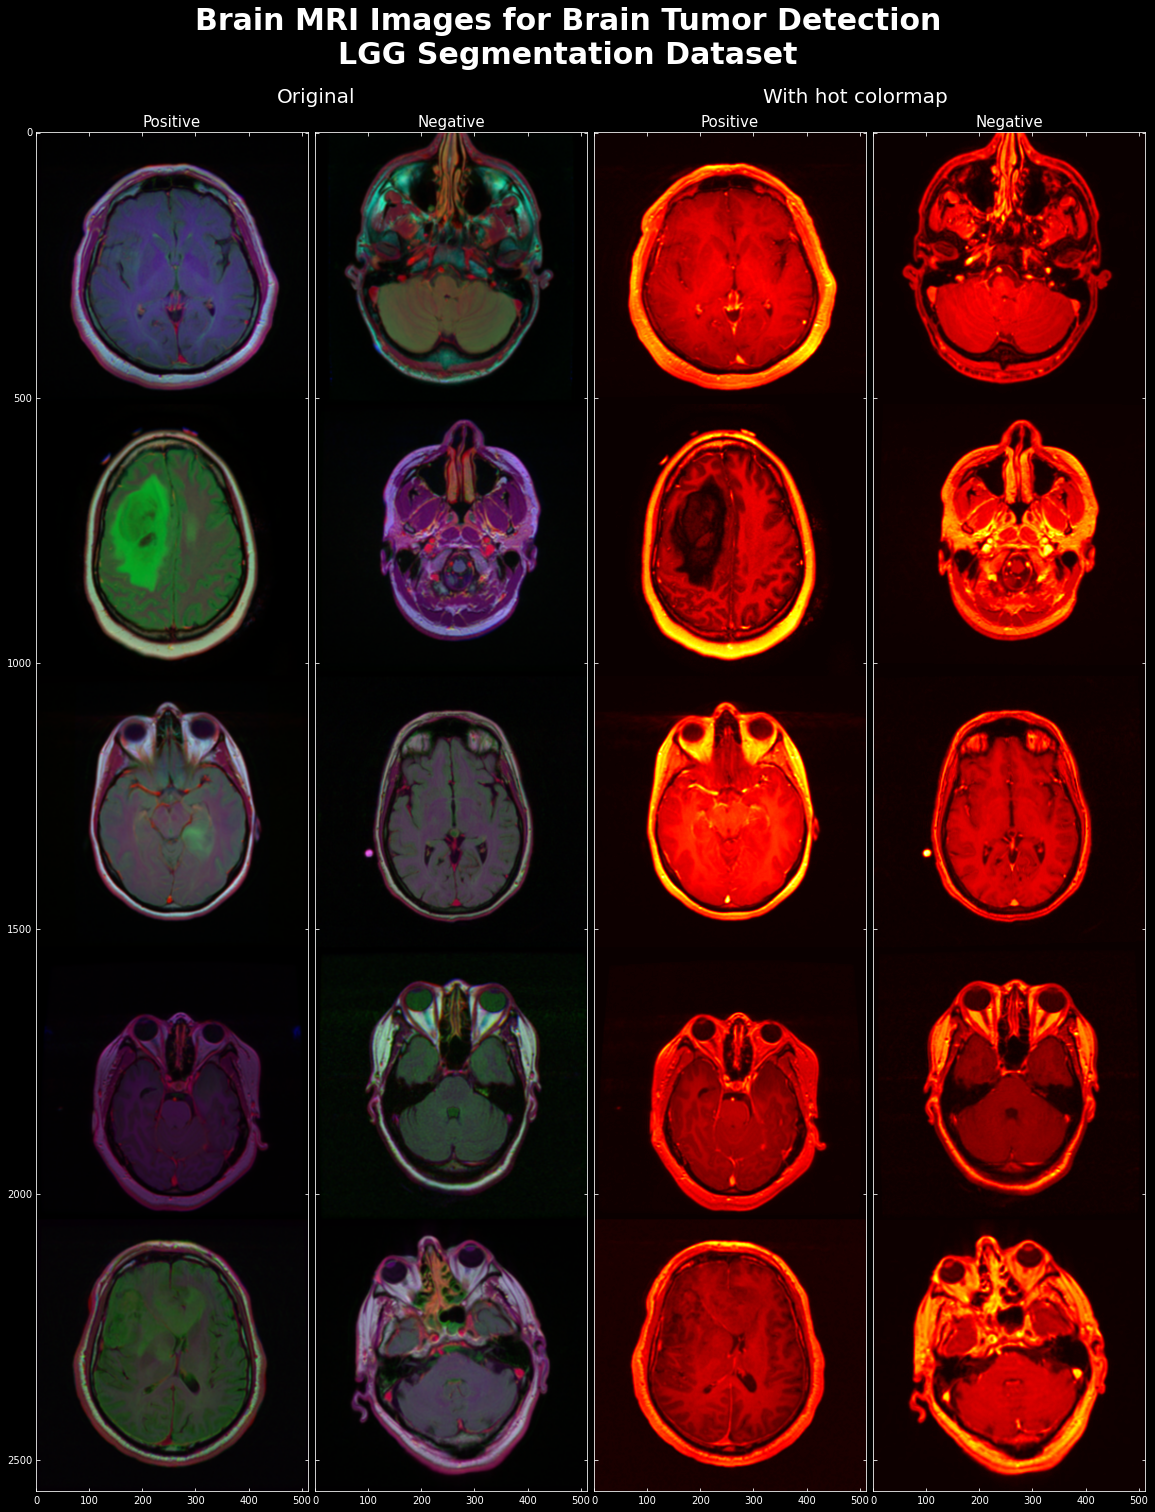

In [21]:
# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[0].grid(False)

grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")
grid[1].grid(False)

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[2].grid(False)

grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")
grid[3].grid(False)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

In [22]:
# masks
sample_df = dff[dff["diagnosis"] == 1].sample(5).values

sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

In [23]:
sample_img_arr = np.hstack(sample_imgs[::2])
sample_mask_arr = np.hstack(sample_imgs[1::2])

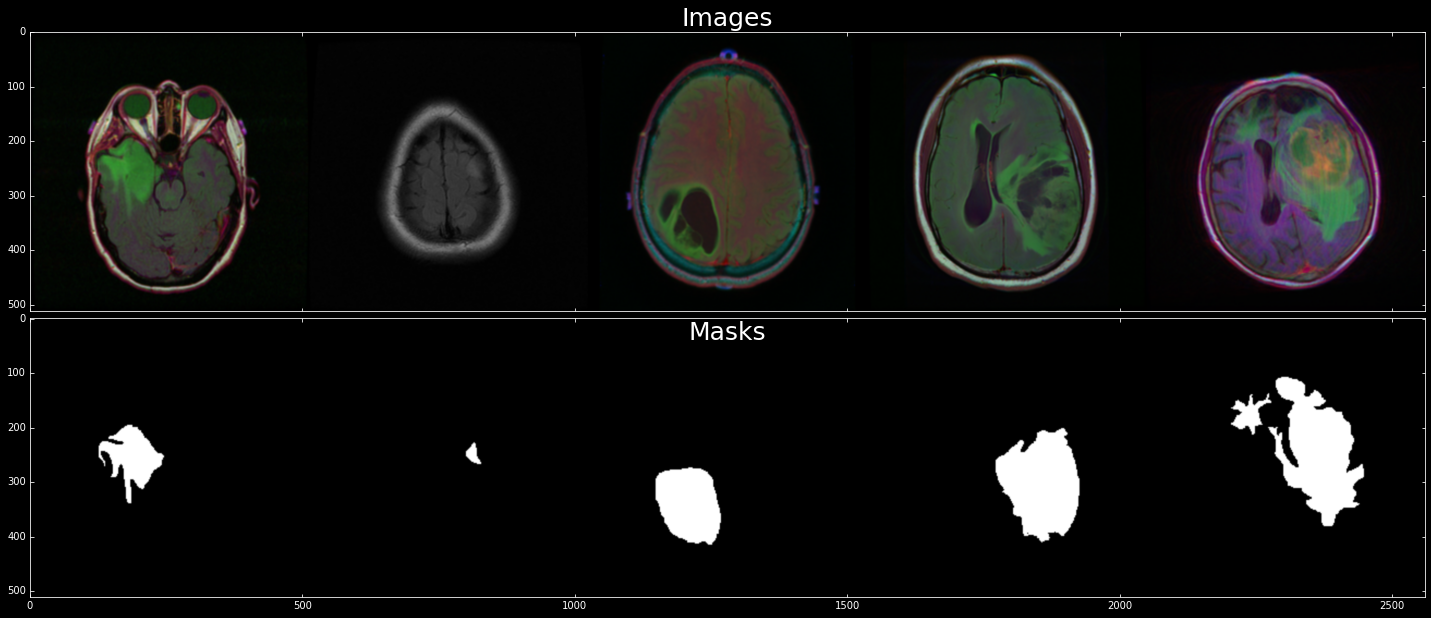

In [24]:
# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_img_arr)
grid[0].set_title("Images", fontsize=25)
grid[0].axis("off")
grid[0].grid(False)

grid[1].imshow(sample_mask_arr)
grid[1].set_title("Masks", fontsize=25, y=0.9)
grid[1].axis("off")
grid[1].grid(False)

plt.show()

# Data Augmentation and Loader

In [25]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=c97f046a75eae1b83c0cef379a54fa2a8ff9f1c4a6d991a50e7fe126a95c65c6
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as AT
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.model_selection import train_test_split

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
class BrainMRIDataset:
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
        
        return image, mask

In [29]:
PATCH_SIZE = 128

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    AT.CLAHE(p=0.5),
    AT.ChannelShuffle(p=0.25),
    AT.RandomBrightness(p=0.2),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensor(),
    
])

In [30]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [31]:
train_dataset = BrainMRIDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

test_dataset = BrainMRIDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

In [32]:
def show_aug(inputs, nrows=5, ncols=5, norm=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


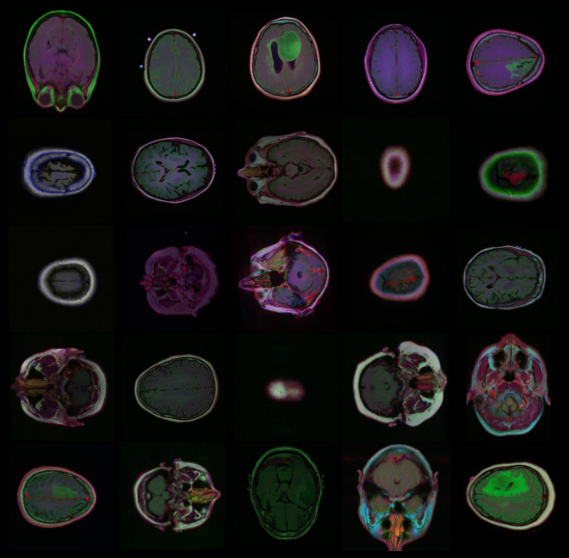

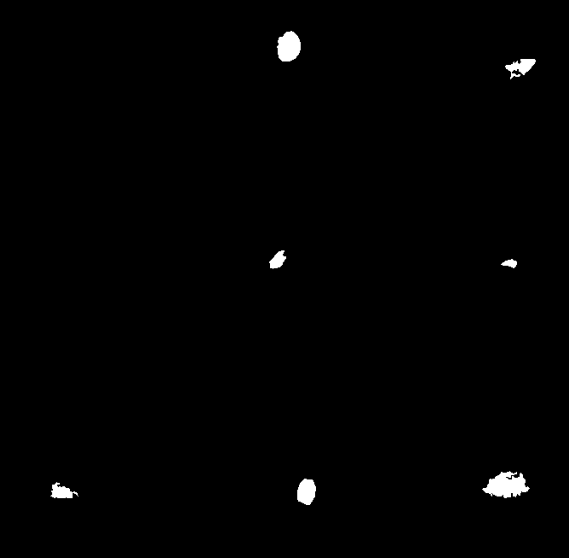

In [33]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

# Models

# Vanilla U-Net

In [34]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_channels, out_channels, 3, padding=1),
    nn.ReLU(inplace=True))

In [35]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)    
        
        conv2 = self.conv_down2(x) 
        x = self.maxpool(conv2)    
        
        conv3 = self.conv_down3(x)  
        x = self.maxpool(conv3)     
        
        x = self.conv_down4(x)      
        x = self.upsample(x)        
        
        x = torch.cat([x, conv3], dim=1) 
        
        x = self.conv_up3(x) 
        x = self.upsample(x) 
        
        x = torch.cat([x, conv2], dim=1) 

        x = self.conv_up2(x)
        x = self.upsample(x)   
        
        x = torch.cat([x, conv1], dim=1)
        
        x = self.conv_up1(x)
        
        out = self.last_conv(x)
        out = torch.sigmoid(out)
        
        return out

In [36]:
unet = UNet(n_classes=1).to(device)

In [37]:
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

# UNet + FPN

In [38]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3,3), stride=1, padding=1, bias=False),
        nn.GroupNorm(32, out_channels),
        nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x
    
class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()
        
        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]
        
        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))
                
        self.block = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.block(x)

In [39]:
class FPN(nn.Module):
    def __init__(self, n_classes=1, pyramid_channels=256,
                segmentation_channels=256):
        super().__init__()
        
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)
        
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.latlayer1 =nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels,
                             n_upsamples=n_upsamples) for n_upsamples in [0, 1, 2, 3]
        ])
        
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _, _, h, w = y.size()
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)+y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)
        
    def forward(self, x):
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4))
        
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2))
        
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4*h, 4*w)
        out = torch.sigmoid(out)
        return out

In [40]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# UNet with ResNeXt50 Backbone

In [41]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()
        
        self.convrelu = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.convrelu(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels//4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels//4, in_channels//4,
                                         kernel_size=4, stride=2,
                                        padding=1, output_padding=0)
        self.conv2 = ConvRelu(in_channels//4, out_channels, 1, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        
        return x

In [42]:
class ResNeXtUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])
        
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])
        
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
        
    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        
        out = torch.sigmoid(out)
        
        return out

In [43]:
resnextunet = ResNeXtUNet().to(device)
output = resnextunet(torch.randn(1,3,256,256).to(device))
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

torch.Size([1, 1, 256, 256])


# DeepLabv3 with ResNet101 Backbone

# Segmentation Metric

In [44]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

# Segmentation Loss

In [45]:
def dice_coef_loss(inputs, target):
    smooth = 1.0 
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [46]:
# sanity check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Early Stopping

In [47]:
# early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [48]:
early_stopping = EarlyStopping(tolerance=5, min_delta=10)

# Training

In [49]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
        
    for epoch in range(num_epochs):
        
        model.train()
        
        losses = []
        train_iou = []
        
        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        # early stopping
        early_stopping(np.array(losses).mean(), val_mean_iou)
        if early_stopping.early_stop:
            print("[INFO] Early stopping at epoch:", i)
            break
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [50]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().detach())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [51]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

## Train UNet

In [52]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), weight_decay=1e-3)

In [53]:
%%time
num_ep = 50

unet_lh, unet_th, unet_vh = train_model("Vanilla_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_ep)

[INFO] Model is initializing... Vanilla_UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.7143237424393495 
Mean DICE on train: 0.3502721236272534 
Mean DICE on validation: 0.46946601408482663


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.610642862568299 
Mean DICE on train: 0.4647853290583433 
Mean DICE on validation: 0.5086216950729693


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.5870634657641252 
Mean DICE on train: 0.4883536901570882 
Mean DICE on validation: 0.5434786115817037


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.5500679269433022 
Mean DICE on train: 0.5159276469042169 
Mean DICE on validation: 0.4827350751226786


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.5573686668028434 
Mean DICE on train: 0.5094188455947097 
Mean DICE on validation: 0.5676850327130101


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.516161872074008 
Mean DICE on train: 0.5462675616347166 
Mean DICE on validation: 0.5478280050267331


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.5116070320208868 
Mean DICE on train: 0.5469440034874621 
Mean DICE on validation: 0.5460750700825056


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.4959099562217792 
Mean DICE on train: 0.5614105496038991 
Mean DICE on validation: 0.5325239727388792


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.4736572359999021 
Mean DICE on train: 0.5839365935818974 
Mean DICE on validation: 0.5831123789561761


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.44416453229884306 
Mean DICE on train: 0.6071395130286451 
Mean DICE on validation: 0.6735044859113236


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.4081726774573326 
Mean DICE on train: 0.6413987082996989 
Mean DICE on validation: 0.636086113943515


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.3887191427250703 
Mean DICE on train: 0.6569092549503518 
Mean DICE on validation: 0.6936800744482563


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.39413781041900314 
Mean DICE on train: 0.6507683792513852 
Mean DICE on validation: 0.6702309639989672


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.36816729220251243 
Mean DICE on train: 0.6758051442856804 
Mean DICE on validation: 0.7341818974733244


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.3709658902138472 
Mean DICE on train: 0.6743626939507711 
Mean DICE on validation: 0.7540355944608201


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.37230209124584995 
Mean DICE on train: 0.6721965148787565 
Mean DICE on validation: 0.5607711046132272


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.36527618604401746 
Mean DICE on train: 0.6774125567036393 
Mean DICE on validation: 0.6675419883714839


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.3458065884808699 
Mean DICE on train: 0.6963862201990721 
Mean DICE on validation: 0.7503802232396731


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.3410975637535254 
Mean DICE on train: 0.6988239788360515 
Mean DICE on validation: 0.6674944380910693


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.33205876673261325 
Mean DICE on train: 0.707187523445828 
Mean DICE on validation: 0.7212027653790736


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.3620510853827 
Mean DICE on train: 0.6807694204101691 
Mean DICE on validation: 0.6868085102607668


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.36580840684473515 
Mean DICE on train: 0.6795305793500862 
Mean DICE on validation: 0.7875430679538442


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.3458856847137213 
Mean DICE on train: 0.6951995157054889 
Mean DICE on validation: 0.7756253067976143


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.319375953823328 
Mean DICE on train: 0.7182623559258988 
Mean DICE on validation: 0.7989286987419894


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.3211893532425165 
Mean DICE on train: 0.7177355056012907 
Mean DICE on validation: 0.7745663501381751


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.326896162579457 
Mean DICE on train: 0.7128185865157922 
Mean DICE on validation: 0.7414378675735611


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.3370922499646743 
Mean DICE on train: 0.7039384271004294 
Mean DICE on validation: 0.709133036173917


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.31255306775371233 
Mean DICE on train: 0.7246376814570666 
Mean DICE on validation: 0.7486006077657229


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.31612748677531877 
Mean DICE on train: 0.7215995379928402 
Mean DICE on validation: 0.6379514527637572


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.30535902579625446 
Mean DICE on train: 0.7320420783368772 
Mean DICE on validation: 0.7827502982668367


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.2997770234942436 
Mean DICE on train: 0.7341260512665182 
Mean DICE on validation: 0.7999589012520631


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.28811004472275575 
Mean DICE on train: 0.7473189469620962 
Mean DICE on validation: 0.7954631277613093


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.28320182065169014 
Mean DICE on train: 0.7511451561249449 
Mean DICE on validation: 0.7757133620239514


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.2816251238187154 
Mean DICE on train: 0.7525147598802315 
Mean DICE on validation: 0.7519342447496986


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.29471363468716544 
Mean DICE on train: 0.7399938939991453 
Mean DICE on validation: 0.7651627022087996


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.30215231478214266 
Mean DICE on train: 0.7327970584184482 
Mean DICE on validation: 0.7740144891079977


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.30696370887259644 
Mean DICE on train: 0.7290683450741781 
Mean DICE on validation: 0.7866468208369387


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.2830720850576957 
Mean DICE on train: 0.750120440662613 
Mean DICE on validation: 0.8181815789678583


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.2679081315174699 
Mean DICE on train: 0.7638964845441681 
Mean DICE on validation: 0.8147753245092539


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.2846438343326251 
Mean DICE on train: 0.7481095901614642 
Mean DICE on validation: 0.8051764219962466


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.2913825526212653 
Mean DICE on train: 0.7433601388371881 
Mean DICE on validation: 0.8301258873127659


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.289697101029257 
Mean DICE on train: 0.7442713510374936 
Mean DICE on validation: 0.832479280681265


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.2775878378500541 
Mean DICE on train: 0.7554875896744059 
Mean DICE on validation: 0.7881226809611542


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.2980726466824611 
Mean DICE on train: 0.7386912854081982 
Mean DICE on validation: 0.7963533989123739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.27758286061386267 
Mean DICE on train: 0.7557428070585972 
Mean DICE on validation: 0.8132360442496843


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.25977265648543835 
Mean DICE on train: 0.7715421715442538 
Mean DICE on validation: 0.7637104199014233


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.28540366018811864 
Mean DICE on train: 0.7483270160108619 
Mean DICE on validation: 0.8060152337399739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.2518435579414169 
Mean DICE on train: 0.7780116787733767 
Mean DICE on validation: 0.7838892494484699


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.2769752557078997 
Mean DICE on train: 0.7563623179667011 
Mean DICE on validation: 0.7411674084209157


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.26253483338902395 
Mean DICE on train: 0.7685457301545229 
Mean DICE on validation: 0.8272802399322544
CPU times: user 44min 23s, sys: 39.8 s, total: 45min 3s
Wall time: 46min 39s


In [54]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

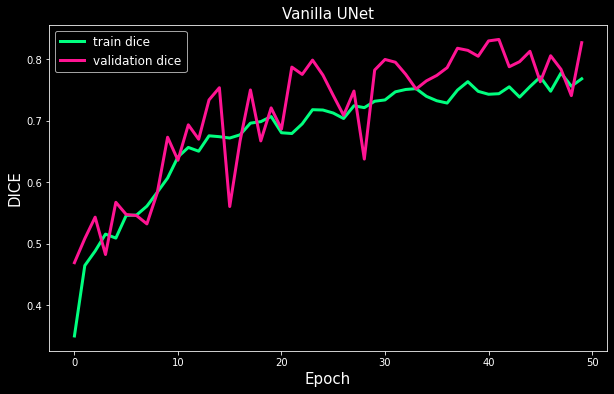

In [55]:
plot_model_history("Vanilla UNet", unet_th, unet_vh, num_ep)

# Train FPN

In [56]:
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), weight_decay=1e-3)

In [57]:
%%time
num_ep = 50

fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, num_ep)

[INFO] Model is initializing... FPN


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.8690435136357944 
Mean DICE on train: 0.2031954714403498 
Mean DICE on validation: 0.45877741270422


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.6017104660471281 
Mean DICE on train: 0.4817826447329422 
Mean DICE on validation: 0.5212608264721963


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.5114494894941648 
Mean DICE on train: 0.5526294638997643 
Mean DICE on validation: 0.6781926201033391


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.48021632495025796 
Mean DICE on train: 0.5830413291353987 
Mean DICE on validation: 0.6089050838002165


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.4555573490758737 
Mean DICE on train: 0.6063892135562682 
Mean DICE on validation: 0.6491871992038638


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.4374910476307074 
Mean DICE on train: 0.6194074012427048 
Mean DICE on validation: 0.6642948207714275


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.42874932872752347 
Mean DICE on train: 0.6275041293142806 
Mean DICE on validation: 0.6869106756118545


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.4107094502697388 
Mean DICE on train: 0.645925230979854 
Mean DICE on validation: 0.6899750282961029


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.4137882772833109 
Mean DICE on train: 0.6392654637565066 
Mean DICE on validation: 0.6266070692751531


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.42955884474019207 
Mean DICE on train: 0.62529842611475 
Mean DICE on validation: 0.6169084708371737


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.3957694721718629 
Mean DICE on train: 0.6565929850686038 
Mean DICE on validation: 0.739420142945574


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.4008169456074635 
Mean DICE on train: 0.6504592718430248 
Mean DICE on validation: 0.6965862001168


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.3782975780467192 
Mean DICE on train: 0.6714751700210381 
Mean DICE on validation: 0.7368893847062503


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.38333174847066404 
Mean DICE on train: 0.6671448556190362 
Mean DICE on validation: 0.723355723093503


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.3658373922109604 
Mean DICE on train: 0.6820661427065543 
Mean DICE on validation: 0.7741022903106612


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.35916146722932657 
Mean DICE on train: 0.6882749254364403 
Mean DICE on validation: 0.7719224724808953


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.36871748603880405 
Mean DICE on train: 0.679249585195933 
Mean DICE on validation: 0.7470859062606134


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.3725350261976322 
Mean DICE on train: 0.6779906280850727 
Mean DICE on validation: 0.6943642547624437


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.3320009173204502 
Mean DICE on train: 0.7122339573888552 
Mean DICE on validation: 0.7704139296855222


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.3227632130185763 
Mean DICE on train: 0.7210789453368507 
Mean DICE on validation: 0.800456856542269


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.31796474878986675 
Mean DICE on train: 0.7224427120084177 
Mean DICE on validation: 0.7944586857084093


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.31246776282787325 
Mean DICE on train: 0.7308325753047508 
Mean DICE on validation: 0.7546894198354274


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.30833529370526475 
Mean DICE on train: 0.7351232601531074 
Mean DICE on validation: 0.8219774969156665


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.3083806117375692 
Mean DICE on train: 0.7330539363314605 
Mean DICE on validation: 0.8200641683072962


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.30285100849966207 
Mean DICE on train: 0.7370074223026581 
Mean DICE on validation: 0.8526550966836809


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.28474408586819966 
Mean DICE on train: 0.7550528708686187 
Mean DICE on validation: 0.8143318322738365


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.2860775082061688 
Mean DICE on train: 0.7531803055132209 
Mean DICE on validation: 0.8201877632136175


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.2773211551209291 
Mean DICE on train: 0.7600534280792769 
Mean DICE on validation: 0.8565861339419282


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.281295741101106 
Mean DICE on train: 0.7570977029591736 
Mean DICE on validation: 0.8200999809195224


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.2700996613750855 
Mean DICE on train: 0.7674825928313077 
Mean DICE on validation: 0.8241780770854586


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.2647936479498943 
Mean DICE on train: 0.7720649741979579 
Mean DICE on validation: 0.8100418472416417


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.27842038733263813 
Mean DICE on train: 0.7595586243146424 
Mean DICE on validation: 0.8055593490646277


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.2659579776227474 
Mean DICE on train: 0.7694754645902484 
Mean DICE on validation: 0.8491025226473927


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.24903615961472195 
Mean DICE on train: 0.7862969279181357 
Mean DICE on validation: 0.8557790934020653


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.25187881477177143 
Mean DICE on train: 0.7822237473806131 
Mean DICE on validation: 0.8490348155422717


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.24122174630562465 
Mean DICE on train: 0.7926619568849197 
Mean DICE on validation: 0.8579463537511671


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.24691720809787512 
Mean DICE on train: 0.7878342889294544 
Mean DICE on validation: 0.8387131131054683


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.23557955144594114 
Mean DICE on train: 0.7981718628190647 
Mean DICE on validation: 0.8330675823580945


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.23787443997959296 
Mean DICE on train: 0.7953249556614616 
Mean DICE on validation: 0.8266101956411236


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.22749740307529767 
Mean DICE on train: 0.8042521551391845 
Mean DICE on validation: 0.8549132419184686


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.23048899670441944 
Mean DICE on train: 0.8015199053690315 
Mean DICE on validation: 0.845082223089187


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.21368038083116214 
Mean DICE on train: 0.8170838256549281 
Mean DICE on validation: 0.8523394834724488


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.22241381431619325 
Mean DICE on train: 0.8085412480780501 
Mean DICE on validation: 0.8588586716452862


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.2232683005432288 
Mean DICE on train: 0.8082604527077716 
Mean DICE on validation: 0.8191203990242841


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.2149489094192783 
Mean DICE on train: 0.8152776689329577 
Mean DICE on validation: 0.8618311021510362


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.21819925835976997 
Mean DICE on train: 0.8129144567605718 
Mean DICE on validation: 0.8213226106874884


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.21755515125890573 
Mean DICE on train: 0.8130136543305251 
Mean DICE on validation: 0.8715052119266936


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.21028738487511872 
Mean DICE on train: 0.8195089051693804 
Mean DICE on validation: 0.8907242253992482


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.20716365439196427 
Mean DICE on train: 0.8218674603359799 
Mean DICE on validation: 0.8657977337488078


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.2038212097560366 
Mean DICE on train: 0.8255315629619292 
Mean DICE on validation: 0.8472091662491731
CPU times: user 29min 24s, sys: 39.6 s, total: 30min 4s
Wall time: 31min 36s


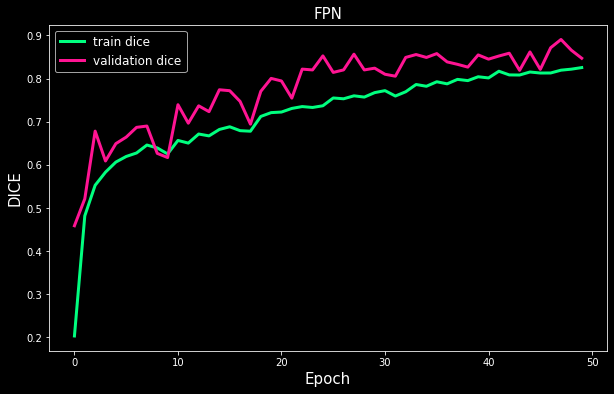

In [58]:
plot_model_history("FPN", fpn_th, fpn_vh, num_ep)

# Training: ResNeXt-UNet

In [59]:
resnextunet_optimizer = torch.optim.Adamax(resnextunet.parameters(), weight_decay=1e-3)

In [60]:
%%time
num_ep = 50

resnextunet_lh, resnextunet_th, resnextunet_vh = train_model("ResNeXtUNet", resnextunet, train_dataloader, val_dataloader, bce_dice_loss, resnextunet_optimizer, False, num_ep)

[INFO] Model is initializing... ResNeXtUNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.6770572777837515 
Mean DICE on train: 0.37662223887316565 
Mean DICE on validation: 0.6342229327021813


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.4145735915750265 
Mean DICE on train: 0.6339961644114663 
Mean DICE on validation: 0.6695695834355587


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.3565985795110464 
Mean DICE on train: 0.684357527610152 
Mean DICE on validation: 0.7496823557417598


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.31284437105059626 
Mean DICE on train: 0.7240655753787872 
Mean DICE on validation: 0.7019440208145714


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.2807885361214479 
Mean DICE on train: 0.7517937105932365 
Mean DICE on validation: 0.7922546818335994


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.26886410377919673 
Mean DICE on train: 0.7644102080483764 
Mean DICE on validation: 0.7794734615473377


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.2580698703105251 
Mean DICE on train: 0.7726877697150368 
Mean DICE on validation: 0.8077833335362947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.23051634250829617 
Mean DICE on train: 0.7972580175077506 
Mean DICE on validation: 0.834569807876581


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.2187295394639174 
Mean DICE on train: 0.8071762066383604 
Mean DICE on validation: 0.8027924938553237


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.22319143824279308 
Mean DICE on train: 0.8024449698571849 
Mean DICE on validation: 0.8471954101050586


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.21376921702176332 
Mean DICE on train: 0.8116824634485357 
Mean DICE on validation: 0.7869502318569559


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.20775226292510826 
Mean DICE on train: 0.8175024077197465 
Mean DICE on validation: 0.8684976439098321


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.19941531630853812 
Mean DICE on train: 0.8243512753137239 
Mean DICE on validation: 0.8692777982103455


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.18968642478187878 
Mean DICE on train: 0.8322428887209957 
Mean DICE on validation: 0.861693041839151


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.18165103681385517 
Mean DICE on train: 0.839725125797996 
Mean DICE on validation: 0.8265509658017058


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.17521636572976906 
Mean DICE on train: 0.8452676850342102 
Mean DICE on validation: 0.8719590815970851


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.1846809597685933 
Mean DICE on train: 0.8369691804500773 
Mean DICE on validation: 0.8837352149456623


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.17169463882843652 
Mean DICE on train: 0.847977595892523 
Mean DICE on validation: 0.7633918847605795


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.1725126772498091 
Mean DICE on train: 0.8477852573960317 
Mean DICE on validation: 0.8931801145928217


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.16335594405730566 
Mean DICE on train: 0.8555976551113265 
Mean DICE on validation: 0.8822878703199114


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.1650717096403241 
Mean DICE on train: 0.8540473948458528 
Mean DICE on validation: 0.9005880047245346


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.17109585149834552 
Mean DICE on train: 0.8488382133059166 
Mean DICE on validation: 0.8897571779064173


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.16713910941034554 
Mean DICE on train: 0.8521794042771245 
Mean DICE on validation: 0.8997372141624181


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.16436505963404974 
Mean DICE on train: 0.8545026909711902 
Mean DICE on validation: 0.9133621599641347


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.15843860556681952 
Mean DICE on train: 0.8604791544831499 
Mean DICE on validation: 0.8354766300141061


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.15698394334564605 
Mean DICE on train: 0.8610334910432779 
Mean DICE on validation: 0.9135432608811385


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.14269699590901533 
Mean DICE on train: 0.8741161056489086 
Mean DICE on validation: 0.8987643549937386


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.1481159473458926 
Mean DICE on train: 0.8693103946043969 
Mean DICE on validation: 0.9065123269689803


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.14654251554359993 
Mean DICE on train: 0.8704182163093191 
Mean DICE on validation: 0.9192275494863099


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.15449110368887584 
Mean DICE on train: 0.8637117468964522 
Mean DICE on validation: 0.8740138581652998


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.14445408868292967 
Mean DICE on train: 0.8723477934838659 
Mean DICE on validation: 0.9271215791158396


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.14458052621533474 
Mean DICE on train: 0.8723815492678815 
Mean DICE on validation: 0.9174389488905809


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.1540731028964122 
Mean DICE on train: 0.8645262399681483 
Mean DICE on validation: 0.855388646351646


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.15207783489798507 
Mean DICE on train: 0.8658730230491334 
Mean DICE on validation: 0.8994434591743485


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.14064041090508303 
Mean DICE on train: 0.8754232722417794 
Mean DICE on validation: 0.9042215387923584


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.14679882451891899 
Mean DICE on train: 0.8704747402482321 
Mean DICE on validation: 0.851698267874511


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.14840491333355507 
Mean DICE on train: 0.8691003755003791 
Mean DICE on validation: 0.9242561193038497


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.14620291863878568 
Mean DICE on train: 0.8712237171192503 
Mean DICE on validation: 0.8667465769413956


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.14510814379900694 
Mean DICE on train: 0.8723395432747405 
Mean DICE on validation: 0.9083576565798079


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.14829715384791295 
Mean DICE on train: 0.8692169284279303 
Mean DICE on validation: 0.9030901820419656


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.14823551885783673 
Mean DICE on train: 0.8687420520665365 
Mean DICE on validation: 0.8656835583218949


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.13442147678385177 
Mean DICE on train: 0.8817688298824614 
Mean DICE on validation: 0.8870354171003919


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.1398318556137383 
Mean DICE on train: 0.876336274626902 
Mean DICE on validation: 0.9190376461437267


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.1394548775628209 
Mean DICE on train: 0.8771438883776698 
Mean DICE on validation: 0.8630519273968971


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.14375278130173683 
Mean DICE on train: 0.8721508327097204 
Mean DICE on validation: 0.8540929427007875


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.1392292843510707 
Mean DICE on train: 0.877542977888577 
Mean DICE on validation: 0.9081880509631816


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.14267724292973677 
Mean DICE on train: 0.8737926401028716 
Mean DICE on validation: 0.9085209173422679


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.1365929054717223 
Mean DICE on train: 0.8795344803318296 
Mean DICE on validation: 0.9119129222520006


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.14702655790994565 
Mean DICE on train: 0.8696897329993567 
Mean DICE on validation: 0.9151354522246089


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.14327316756049793 
Mean DICE on train: 0.873741048749532 
Mean DICE on validation: 0.8894482199642199
CPU times: user 1h 5min 37s, sys: 27min 52s, total: 1h 33min 30s
Wall time: 1h 35min 38s


# UNet: Test on the Data

In [61]:
test_iou = compute_iou(fpn, test_dataloader)
print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Vanilla UNet
Mean IoU of the test images - 80.0%


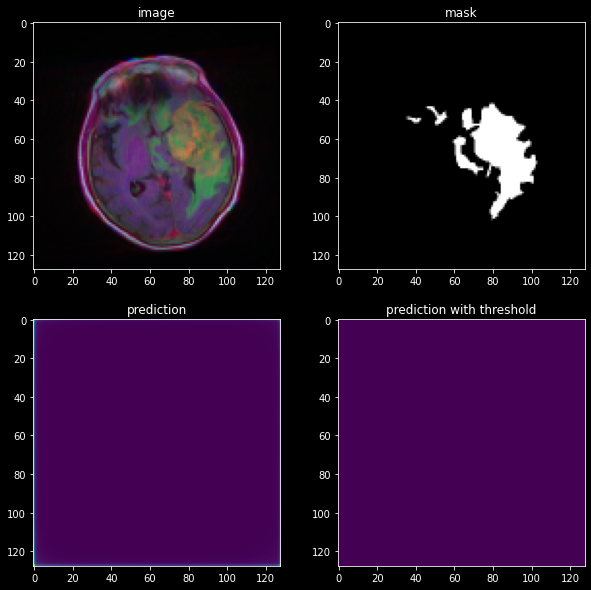

In [62]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = unet(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()

# FPN: Test on the Data

In [63]:
test_iou = compute_iou(fpn, test_dataloader)
print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

FPN
Mean IoU of the test images - 79.0%


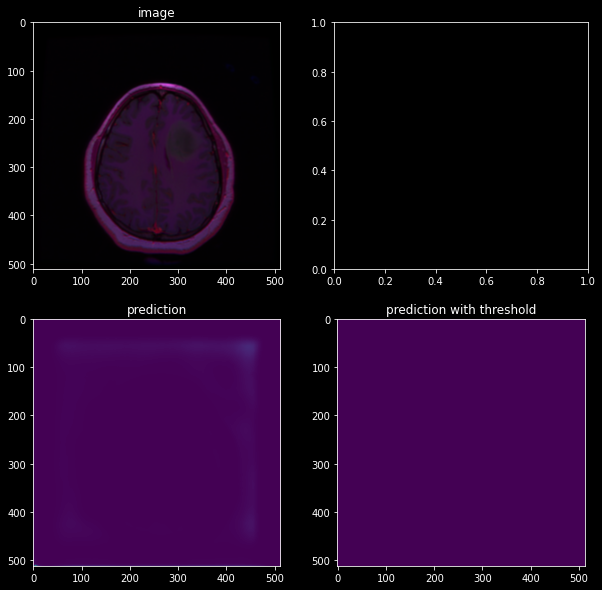

In [64]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]

image = cv2.resize(cv2.imread(test_sample[1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(test_sample[2]), (IMG_SIZE, IMG_SIZE))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = fpn(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t > 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[1, 0].imshow(mask)
ax[1, 0].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()

# ResNeXtUNet: Test on Data

In [65]:
test_iou = compute_iou(resnextunet, test_dataloader)
print(f"""ResNeXtUNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

ResNeXtUNet
Mean IoU of the test images - 93.0%


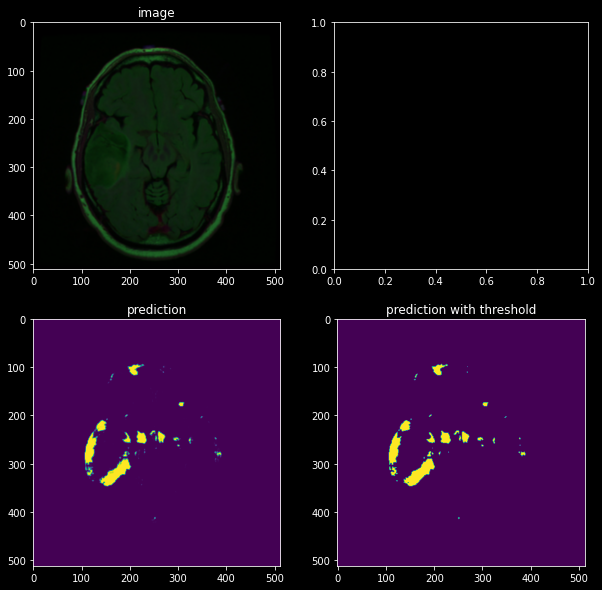

In [66]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]

image = cv2.resize(cv2.imread(test_sample[1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(test_sample[2]), (IMG_SIZE, IMG_SIZE))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = resnextunet(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t > 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[1, 0].imshow(mask)
ax[1, 0].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()